In [1]:
%pip install seaborn
import pandas as pd
import seaborn
import pm4py

In [2]:
# Preparing data

## Let's import the event log dataset in a pandas dataframe
### pm4py uses dataframe as the standard format for event logs

log_df = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/BIS2022/main/Event%20Logs/Road_Traffic_Fine_Management_Process.csv',sep=',')
log_df.rename(columns={'Case ID': 'case:concept:name', 'Complete Timestamp': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True) #change the name to a colum
# log_df = pm4py.format_dataframe(log_df, case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp') # DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0.
# event_log = pm4py.convert_to_event_log(log_df)
# print(event_log)
# convert the 'Date' column to datetime format
log_df['time:timestamp']= pd.to_datetime(log_df['time:timestamp'])

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

#log_df


Number of events: 561470
Number of cases: 150370
Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


In [3]:
# let's count the missing values for each column
null_values = log_df.isnull().sum()
print("Missing values: {}".format(null_values))

Missing values: case:concept:name            0
concept:name                 0
org:resource            410545
time:timestamp               0
Variant                      0
Variant index                0
amount                  331240
dismissal               406404
vehicleClass            411100
totalPaymentAmount      333499
lifecycle:transition         0
article                 411100
points                  411100
expense                 457483
notificationType        481610
lastSent                483241
paymentAmount           483869
matricola               560915
dtype: int64


Events share: concept:name       Add penalty  Appeal to Judge  Create Fine  \
case:concept:name                                              
A1                           0                0            1   
A100                         1                0            1   
A10000                       1                0            1   
A10001                       1                0            1   
A10004                       1                0            1   
...                        ...              ...          ...   
V9995                        1                0            1   
V9996                        0                0            1   
V9997                        1                0            1   
V9998                        1                0            1   
V9999                        1                0            1   

concept:name       Insert Date Appeal to Prefecture  Insert Fine Notification  \
case:concept:name                                                       

<Axes: xlabel='concept:name', ylabel='case:concept:name'>

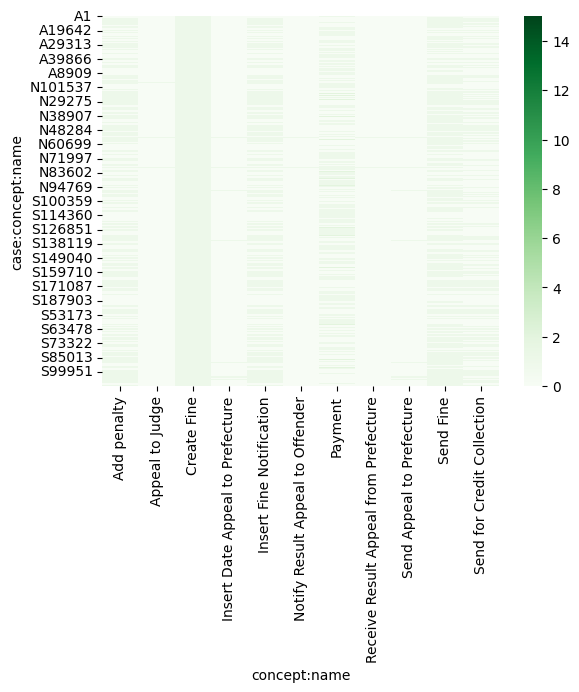

In [10]:
# Listing all the cases. We use crosstab to have a view of the crossing of row/column
events_share = pd.crosstab(log_df['case:concept:name'], log_df['concept:name'])
print("Events share: {}".format(events_share))
# Visualize in heatmap
seaborn.heatmap(events_share, cmap="Greens")

In [17]:
case_durations = log_df.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    FirstOccurrence=('time:timestamp', lambda x: x.min()),
    LastOccurrence=('time:timestamp', lambda x: x.max()),
    Duration=('time:timestamp', lambda x: x.max() - x.min()),
)
print(case_durations)

                   Events FirstOccurrence LastOccurrence Duration
case:concept:name                                                
A1                      2      2006-07-24     2006-12-05 134 days
A100                    5      2006-08-02     2009-03-30 971 days
A10000                  5      2007-03-09     2008-09-09 550 days
A10001                  6      2007-03-19     2007-09-24 189 days
A10004                  5      2007-03-20     2009-03-30 741 days
...                   ...             ...            ...      ...
V9995                   5      2002-09-07     2004-01-10 490 days
V9996                   3      2002-09-07     2002-11-06  60 days
V9997                   5      2002-09-07     2004-01-10 490 days
V9998                   5      2002-09-07     2004-01-10 490 days
V9999                   5      2002-09-07     2004-01-10 490 days

[150370 rows x 4 columns]


In [24]:
print("Mean: {}\nMedian: {}".format(case_durations["Duration"].mean(), case_durations["Duration"].median()))
print("Min: {}\nMax: {}".format(case_durations["Duration"].min(), case_durations["Duration"].max()))

Mean: 341 days 16:06:01.029460664
Median: 198 days 00:00:00
Min: 0 days 00:00:00
Max: 4372 days 00:00:00


In [45]:
filtered_log = pm4py.filter_case_performance(log_df, 0, 0)
print(filtered_log["case:concept:name"].count(), log_df["case:concept:name"].count())

9840 561470


In [46]:
variants = pm4py.get_variants(filtered_log)
print(variants)

{('Create Fine', 'Payment'): 4802, ('Create Fine', 'Send Fine'): 118}


In [47]:
filtered_log = pm4py.filter_variants(log_df, [('Create Fine', 'Send Fine')], retain=True)
variants = pm4py.get_variants(filtered_log)
print(variants)

{('Create Fine', 'Send Fine'): 20385}


In [56]:
variants_filtered = pm4py.filter_variants_top_k(log_df, 10)
variants = pm4py.get_variants(variants_filtered)
variants

{('Create Fine', 'Send Fine'): 20385,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Send for Credit Collection'): 56482,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment'): 9520,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Insert Date Appeal to Prefecture',
  'Add penalty',
  'Send Appeal to Prefecture'): 2497,
 ('Create Fine', 'Payment'): 46371,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment',
  'Payment'): 3736,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Add penalty',
  'Payment',
  'Send for Credit Collection'): 1515,
 ('Create Fine', 'Send Fine', 'Payment'): 3131,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Payment',
  'Add penalty',
  'Payment'): 3301,
 ('Create Fine',
  'Send Fine',
  'Insert Fine Notification',
  'Payment',
  'Add penalty',
  'Send for Credit Collection'): 522}